# Logistic Regression & Hyper parameter tuning on Titanic Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

# 1) Data Preparation
- Import titanic dataset
- analyse the data
- identify the missing values and work on the missing values

## 1.1) Import the data

In [2]:
titanic_df = pd.read_csv('Titanic_original.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1.2) Analyse the data

In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The <b>Survived</b> column is our target/dependent/reponse variable, 1 means the passenger survived, 0 means that the passenger died. 

Several other variables describe the passengers:
- PassengerId: and id given to each traveler on the boat.
- Pclass: the passenger class. It has three possible values: 1,2,3.
- Name
- Sex
- Age
- SibSp: number of siblings and spouses traveling with the passenger
- Parch: number of parents and children traveling with the passenger
- The ticket number
- The ticket fare
- The cabin number
- The port of embarkation. It has three possible values S,C,Q. (C = Cherbourg; Q = Queenstown; S = Southampton) 

Let us check which records in the training data are missing information for the Embarked field. 

# 2) Exploratory Data Analysis

### How many passengers survived and how many died? Is there any relationship with the sex?

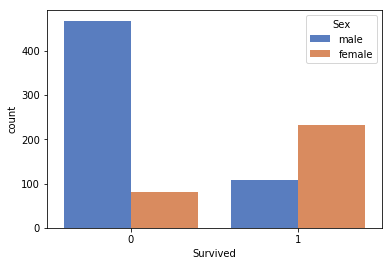

In [4]:
sns.countplot(x='Survived', hue='Sex', data=titanic_df, palette='muted')

### Passenger class and the survival rate

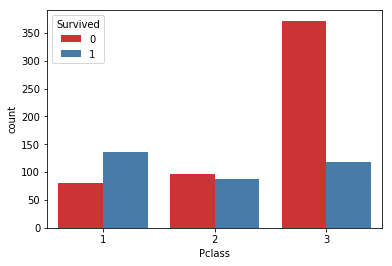

In [5]:
sns.countplot(x='Pclass', hue='Survived', data=titanic_df, palette='Set1')

### Sex and Age - Survival

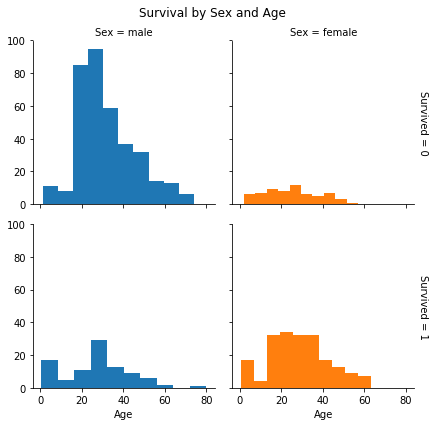

In [6]:
g = sns.FacetGrid(titanic_df, col="Sex", hue='Sex', row="Survived", margin_titles=True)
g.map(plt.hist, "Age");
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Survival by Sex and Age');

### Passenger Class & Age - Survival

Looks like survival rate is more for females compared to males.

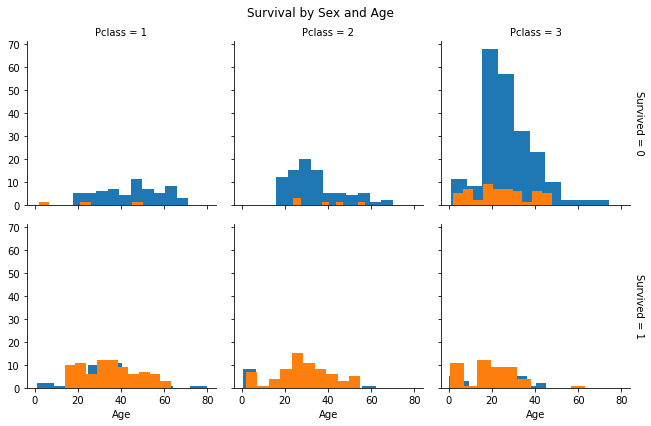

In [7]:
g = sns.FacetGrid(titanic_df, col="Pclass", hue='Sex', row="Survived", margin_titles=True)
g.map(plt.hist, "Age");
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Survival by Sex and Age');

### Fare, Age, Pclass and survival factor

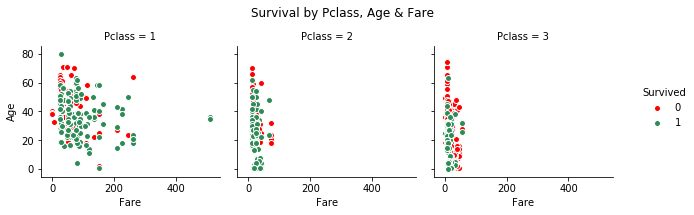

In [8]:
g = sns.FacetGrid(titanic_df, hue="Survived", col="Pclass", margin_titles=True,
                  palette={1:"seagreen", 0:"red"})
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend();
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival by Pclass, Age & Fare');

##### Pclass1 survival seems to be more. Pclass2 seems not to make any difference. Pclass3 survival rate is low.

### Fare, Age, Sex and survival factor

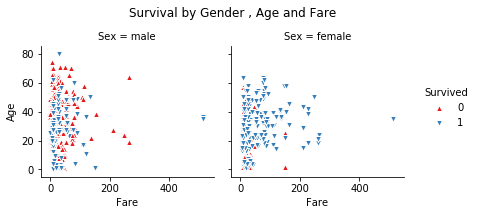

In [9]:
g = sns.FacetGrid(titanic_df, hue="Survived", col="Sex", margin_titles=True,
                palette="Set1",hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival by Gender , Age and Fare');

### Correlation 

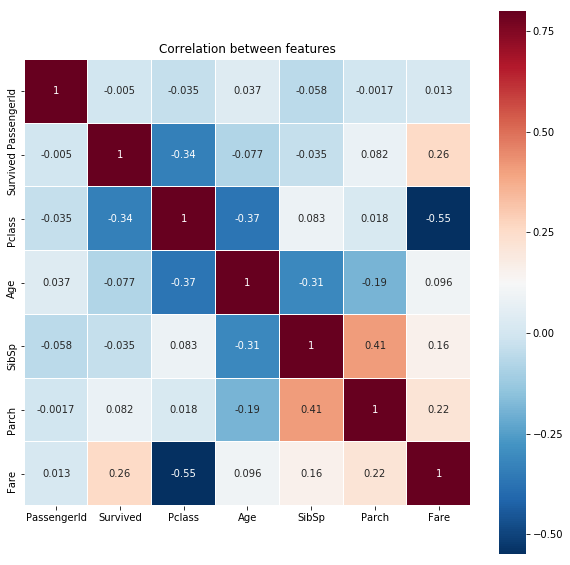

In [10]:
corr=titanic_df.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='RdBu_r',linecolor="white")
plt.title('Correlation between features');

In [11]:
corr.Survived

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

#####  Passenger class and Fare seems to be having higher correlation with the survival rate compared to other features. We need to convert all categorical features to numerical. Lets do that now. 

# 3) Imputation of Missing Data

## 3.1)  Drop the columns where all elements are missing values:

There are 12 columns in total with the following information

In [12]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Find the columns that has null for any columns

In [13]:
titanic_df.columns[titanic_df.isnull().all()].tolist()

[]

##### There are no columns.

## 3.2) Feature Engineering

Before working on missing data, I want to work on creating new features that might be relevant.

- Total number of passengers in the cabin can be found by adding sibsp and parch with the individual (1)
- Individual Fare per passenger can be calculated
- Deck number can be identified from Cabin
- Title can be derived from the name

### 3.2.1) Total Passengers

In [14]:
titanic_df['NumPassengersInCabin'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

### 3.2.2) FarePerPassenger - approximate

In [15]:
titanic_df['FarePerPassenger'] = titanic_df['Fare']/titanic_df['NumPassengersInCabin']

### 3.2.3) Deck

In [16]:
titanic_df['Deck'] = titanic_df.Cabin.str[:1]
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,3.62500,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165,C


### 3.2.4) Title from Passenger Name

In [17]:
titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_df[['Name','Title']].head(2)

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs


In [18]:
pd.crosstab(titanic_df['Title'], titanic_df.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


The above data seems to be pretty accurate

In [19]:
# Mlle, traditionally given to an unmarried woman.
# Mme for woman - married
titanic_df.Title = titanic_df.Title.replace('Mlle', 'Miss')
titanic_df.Title = titanic_df.Title.replace('Ms', 'Miss')
titanic_df.Title = titanic_df.Title.replace('Mme', 'Mrs')

In [20]:
unc_titles = ['Jonkheer','Col','Capt','Countess','Don','Dona','Dr','Lady','Major','Rev','Sir']

In [21]:
titanic_df['Title'] = titanic_df['Title'].replace(unc_titles, 'Uncommon')

In [22]:
# Lets replace all the other titles as "uncommon"
pd.crosstab(titanic_df['Title'], titanic_df.Sex)

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Uncommon,3,20


### 3.2.5) Lone Passenger or Not???!!!

In [23]:
def lonepassenger(passenger):
    if passenger == 1:
        return 'Single'
    else:
        return 'Family'

titanic_df['Single'] = titanic_df.NumPassengersInCabin.apply(lonepassenger)

In [25]:
titanic_df.head(2).T

,0,1
PassengerId,1,2
Survived,0,1
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22,38
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833


## 3.3) Fill Missing values:

In [26]:
titanic_df.isnull().sum()[titanic_df.isnull().sum()>0]

Age         177
Cabin       687
Embarked      2
Deck        687
dtype: int64

#### Age has 177 missing values, Deck 687 and Embarked 2 missing values

### 3.3.1) Missing Data: Embarked

In [27]:
titanic_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


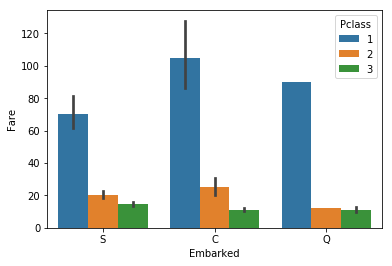

In [28]:
sns.barplot(x="Embarked", y="Fare", hue="Pclass", data=titanic_df);

In [29]:
#Lets check which rows have null Embarked column
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title,Single
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,80.0,B,Miss,Single
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,80.0,B,Mrs,Single


In [30]:
#Pclass1 is missing Embarked values with Fare =80. We need to find the embarkation point for most of passengers with that price range.
# Need not necessarily pclass=1
titanic_df[titanic_df['Pclass']==1]['Embarked'].value_counts()

S    127
C     85
Q      2
Name: Embarked, dtype: int64

In [31]:
titanic_df[['Embarked','Pclass', 'FarePerPassenger']][(titanic_df.FarePerPassenger>75) & (titanic_df.FarePerPassenger <85)]

,Embarked,Pclass,FarePerPassenger
61,NaN,1,80.00000
139,C,1,79.20000
218,C,1,76.29170
256,C,1,79.20000
268,S,1,76.73125
290,S,1,78.85000
310,C,1,83.15830
332,S,1,76.73125
627,S,1,77.95830
681,C,1,76.72920


In [32]:
titanic_df['Embarked'][(titanic_df.FarePerPassenger>75) & (titanic_df.FarePerPassenger <85)].value_counts()

C    6
S    4
Name: Embarked, dtype: int64

#### There are 3 classes S, C, Q 
We can infer that the Embarkation point 'C' is the most occuring for fare price range 75 - 85 (which is also pclass=1). 
Lets replace the missing Embarked values with 'C'

In [33]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('C')

### 3.3.2) Missing Value: Cabin/Deck

In [34]:
titanic_df['Deck'].describe()

count     204
unique      8
top         C
freq       59
Name: Deck, dtype: object

In [35]:
titanic_df['Deck'].isnull().sum()

687

In [36]:
titanic_df[['Pclass', 'Deck']].groupby(['Pclass']).count()

,Deck
Pclass,
1,176
2,16
3,12


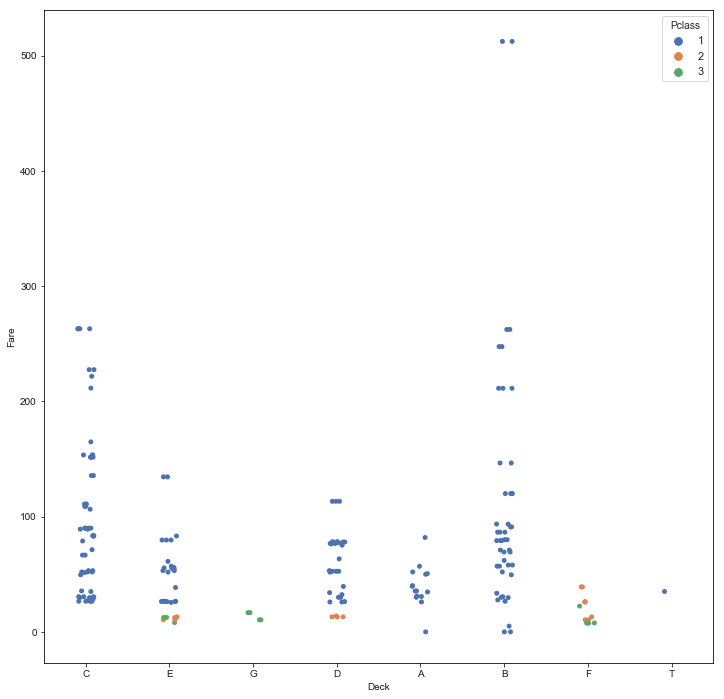

In [37]:
f, ax = plt.subplots(figsize=(12, 12))
sns.set(style="whitegrid")
sns.stripplot('Deck', 'Fare', data=titanic_df, hue='Pclass')

In [38]:
titanic_df[['Deck', 'Pclass', "Fare"]].groupby(['Deck', 'Pclass']).count()

Fare
Deck Pclass      
A    1         15
B    1         47
C    1         59
D    1         29
     2          4
E    1         25
     2          4
     3          3
F    2          8
     3          5
G    3          4
T    1          1

In [39]:
titanic_df.FarePerPassenger[(titanic_df.Deck == 'A') & (titanic_df.Fare !=0)].describe()

count    14.000000
mean     35.108679
std       9.823917
min      19.800000
25%      28.848450
50%      32.827100
75%      38.968750
max      52.000000
Name: FarePerPassenger, dtype: float64

In [40]:
titanic_df.Fare[(titanic_df.Deck == 'B') & (titanic_df.Fare !=0)].describe()

count     45.000000
mean     118.550464
std      108.987208
min        5.000000
25%       57.979200
50%       80.000000
75%      120.000000
max      512.329200
Name: Fare, dtype: float64

In [41]:
titanic_df[['Deck', 'FarePerPassenger']][titanic_df.Deck == 'G'].describe()

,FarePerPassenger
count,4.000000
mean,4.963021
std,0.996307
min,3.487500
25%,4.795313
50%,5.398958
75%,5.566667
max,5.566667


### Calculating approximate fare rates for each deck based on the 25th and 75th percentile of IQR

In [42]:
DeckAFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='A'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='A'], 75))/2

DeckBFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='B'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='B'], 75))/2

DeckCFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='C'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='C'], 75))/2

DeckDFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='D'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='D'], 75))/2

DeckEFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='E'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='E'], 75))/2

DeckFFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='F'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='F'], 75))/2

DeckGFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='G'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='G'], 75))/2

DeckTFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='T'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='T'], 75))/2
print("DeckAFare=",DeckAFare,"DeckBFare=", DeckBFare, "DeckCFare=",DeckCFare, "DeckDFare=",DeckDFare)
print("DeckEFare=",DeckEFare, "DeckFFare=",DeckFFare, "DeckGFare=", DeckGFare, "DeckTFare=",DeckTFare)

DeckAFare= 32.843925 DeckBFare= 55.9974 DeckCFare= 40.37605 DeckDFare= 32.454175
DeckEFare= 26.945318750000002 DeckFFare= 8.7 DeckGFare= 5.180989583333334 DeckTFare= 35.5


### THE DECKS WITH LOWER TO HIGHER RATES ARE
DECKG   
DECKF  
DECKE   
DECKD  
DECKA  
DESCT  
DECKC  
DECKB  

Lets populate the values of deck starting from low value

The decks will be populated based on the fare range of the decks as calculated above.

In [43]:
### populate the Deck values based on the fare range ###
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > 0) & (titanic_df.FarePerPassenger <= DeckGFare)] = titanic_df.Deck.fillna('G')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckGFare) & (titanic_df.FarePerPassenger <= DeckFFare)] = titanic_df.Deck.fillna('F')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckFFare) & (titanic_df.FarePerPassenger <= DeckEFare)] = titanic_df.Deck.fillna('E')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckEFare) & (titanic_df.FarePerPassenger <= DeckDFare)] = titanic_df.Deck.fillna('D')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckDFare) & (titanic_df.FarePerPassenger <= DeckAFare)] = titanic_df.Deck.fillna('A')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckAFare) & (titanic_df.FarePerPassenger <= DeckTFare)] = titanic_df.Deck.fillna('T')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckTFare) & (titanic_df.FarePerPassenger <= DeckCFare)] = titanic_df.Deck.fillna('C')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckCFare)] = titanic_df.Deck.fillna('B')

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [44]:
titanic_df[['Pclass','FarePerPassenger','Deck']][titanic_df.Deck.isnull()]

,Pclass,FarePerPassenger,Deck
179,3,0.0,NaN
271,3,0.0,NaN
277,2,0.0,NaN
302,3,0.0,NaN
413,2,0.0,NaN
466,2,0.0,NaN
481,2,0.0,NaN
597,3,0.0,NaN
633,1,0.0,NaN
674,2,0.0,NaN


In [45]:
#Drop off all the rows wwith passenger fare = 0
titanic_df = titanic_df[titanic_df.FarePerPassenger > 0]
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title,Single
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,3.62500,G,Mr,Family
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165,C,Mrs,Family


In [46]:
titanic_df.shape

(876, 17)

### 3.3.3) Missing Data: Age

In [47]:
titanic_df['Age'].describe()

count    707.000000
mean      29.645219
std       14.558872
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

#### Age ranges from less than 1 to 80 years old with mean age as 30.
Most of the passenger ages are in the range of 21 to 39

Text(0,0.5,'Frequency')

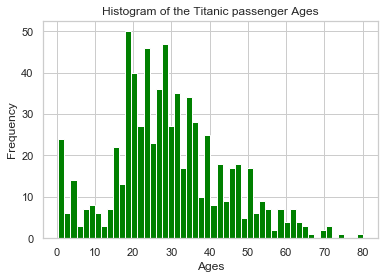

In [48]:
titanic_df['Age'].plot.hist(bins=50, color='green')
Title = 'Histogram of the Titanic passenger Ages'
X = 'Ages'
y = 'Frequency'
plt.title(Title)
plt.xlabel(X)
plt.ylabel(y)     

#### I want to specify the Age based on the Title from the name
Age for all titles with Mr will be the mean of all titles with Mr.

In [49]:
titles = ['Master', 'Miss', 'Mr', 'Mrs']
titanic_df[(titanic_df['Title']== 'Uncommon')& (titanic_df['Age'].isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title,Single
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,NaN,C,1,39.6,C,Uncommon,Single


Only one missing info for the title Uncommon (Dr)

In [51]:
titanic_df[(titanic_df['Title'] == 'Uncommon')]['Age'].mean()

45.904761904761905

In [54]:
titanic_df.Age.loc[titanic_df['Title'] == 'Uncommon'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Uncommon')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [55]:
titanic_df[(titanic_df['Title'] == 'Master')]['Age'].mean()

4.574166666666667

In [56]:
titanic_df[(titanic_df['Title'] == 'Mrs')]['Age'].mean()

35.788990825688074

In [57]:
titanic_df.Age.loc[titanic_df['Title'] == 'Master'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Master')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
titanic_df.Age.loc[titanic_df['Title'] == 'Mr'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Mr')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [59]:
titanic_df.Age.loc[titanic_df['Title'] == 'Miss'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Miss')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [60]:
titanic_df.Age.loc[titanic_df['Title'] == 'Mrs'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Mrs')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [61]:
titanic_df.Age.isnull().sum()

0

Text(0,0.5,'Frequency')

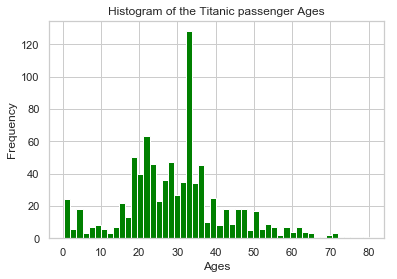

In [62]:
titanic_df['Age'].plot.hist(bins=50, color='green')
Title = 'Histogram of the Titanic passenger Ages'
X = 'Ages'
y = 'Frequency'
plt.title(Title)
plt.xlabel(X)
plt.ylabel(y)     

## 3.4) Drop off unwanted columns

In [64]:
titanic_df.head(2).T

,0,1
PassengerId,1,2
Survived,0,1
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22,38
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833


Drop off the following columns:  
Name  
Ticket  
Cabin  
SibSp  
Parch  

In [65]:
titanic_df = titanic_df.drop(columns = ['Name', 'Ticket', 'Cabin', 'FarePerPassenger', 'SibSp', 'Parch'])
titanic_df.head(3)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,NumPassengersInCabin,Deck,Title,Single
0,1,0,3,male,22.0,7.2500,S,2,G,Mr,Family
1,2,1,1,female,38.0,71.2833,C,2,C,Mrs,Family
2,3,1,3,female,26.0,7.9250,S,1,F,Miss,Single


## 3.5) Convert categorical to numerical 

In [66]:
titanic_df = pd.get_dummies(data=titanic_df, columns=['Sex', 'Embarked', 'Deck', 'Title', 'Single'])
titanic_df.tail(3)

,PassengerId,Survived,Pclass,Age,Fare,NumPassengersInCabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Deck_F,Deck_G,Deck_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Uncommon,Single_Family,Single_Single
888,889,0,3,21.845638,23.45,4,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
889,890,1,1,26.000000,30.00,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
890,891,0,3,32.000000,7.75,1,0,1,0,1,...,1,0,0,0,0,1,0,0,0,1


## 3.6) Statistical summary of the prepared dataset: 
Numerical variables

In [68]:
titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,876.0,444.794521,257.806393,1.0000,220.750000,444.5,667.250000,891.0000
Survived,876.0,0.389269,0.487863,0.0000,0.000000,0.0,1.000000,1.0000
Pclass,876.0,2.315068,0.835663,1.0000,2.000000,3.0,3.000000,3.0000
Age,876.0,29.688562,13.354711,0.4200,21.845638,30.0,35.788991,80.0000
Fare,876.0,32.755650,49.936826,4.0125,7.925000,14.5,31.275000,512.3292
NumPassengersInCabin,876.0,1.920091,1.622839,1.0000,1.000000,1.0,2.000000,11.0000
Sex_female,876.0,0.358447,0.479818,0.0000,0.000000,0.0,1.000000,1.0000
Sex_male,876.0,0.641553,0.479818,0.0000,0.000000,1.0,1.000000,1.0000
Embarked_C,876.0,0.194064,0.395704,0.0000,0.000000,0.0,0.000000,1.0000
Embarked_Q,876.0,0.087900,0.283311,0.0000,0.000000,0.0,0.000000,1.0000


In [69]:
tcorr = titanic_df.corr()

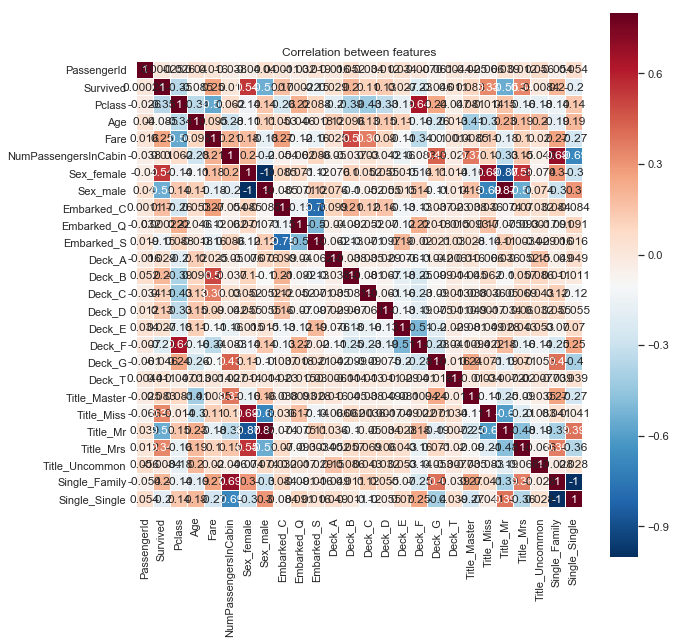

In [70]:
plt.figure(figsize=(10, 10))

sns.heatmap(tcorr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='RdBu_r',linecolor="white")
plt.title('Correlation between features');

In [71]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'Fare',
       'NumPassengersInCabin', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D',
       'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Uncommon', 'Single_Family',
       'Single_Single'],
      dtype='object')

## 2) Logistic Regression - Default Parameters

This is binary classification supervised problem

In [73]:
# Importing modules
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score


In [74]:
X = titanic_df.drop(['PassengerId','Survived'], axis=1)
y = titanic_df.Survived

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(613, 24) (613,) (263, 24) (263,)


In [76]:
# Create logistic regression object
logreg = LogisticRegression()

# Train the model using the training sets and check score
logreg.fit(X_train, y_train)

# Predict Logistic regression output - 0 or 1
log_predicted= logreg.predict(X_test)

# Prediction of probabilities
log_predicted_prob = logreg.predict_proba(X_test)[:,1] 

# Score for train and test
logreg_score = round(logreg.score(X_train, y_train) * 100, 2)
logreg_score_test = round(logreg.score(X_test, y_test) * 100, 2)

In [77]:
print('Logistic Regression Training Score: \n', logreg_score)
print('Logistic Regression Test Score: \n', logreg_score_test)

Logistic Regression Training Score: 
 83.36
Logistic Regression Test Score: 
 79.09


In [78]:
print('Accuracy: \n', accuracy_score(y_test,log_predicted))
print('Confusion Matrix: \n', confusion_matrix(y_test,log_predicted))
print('Classification Report: \n', classification_report(y_test,log_predicted))

Accuracy: 
 0.7908745247148289
Confusion Matrix: 
 [[133  22]
 [ 33  75]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.80      0.86      0.83       155
          1       0.77      0.69      0.73       108

avg / total       0.79      0.79      0.79       263



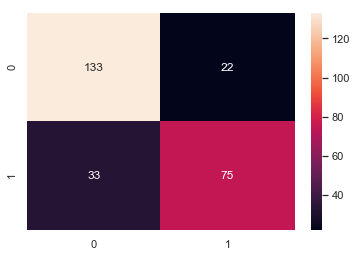

In [79]:
sns.heatmap(confusion_matrix(y_test,log_predicted),annot=True,fmt="d")

In [80]:
log_predicted_prob[:10]

array([0.07108078, 0.34763616, 0.97227855, 0.91662133, 0.12486656,
       0.8559635 , 0.09517577, 0.07765424, 0.02602096, 0.89610799])

In [81]:
log_predicted[:10] ## All probabilities > 0.5 are 1; else 0

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 1], dtype=int64)

# 3) Hyper parameter tuning

Objective is:
- use GridSearchCV to fit the logistic regression with a dictionary of values for C 
- execute gridsearch for different cross validation values (cv)
- Identify the best value for the hyper parameter (in our case, C) using the accuracy score.
- For different values of C, evaluate the model with L1 and L2 penalty, plot accuracy vs different C values
- Note down accuracy, sensitivity, selectivity, F1-score for all combinations and pick the final model.
- Asses the performance of the chosen model and explain.

## 3.1) GridSearchCV for different values of C, cross validation (cv) = 5, penalty=L1

In [82]:
log1 = LogisticRegression(penalty='l1')

In [83]:
#hparameters = [ {'penalty': ['l1'], 'solver': [ 'liblinear',  'saga'], 'multi_class': ['ovr']}, 
#              {'penalty': ['l2'], 'solver': ['lbfgs', 'sag', 'newton-cg'], 'multi_class': ['ovr', 'multinomial']}, 
#              {'C': (.01, .001, .0001, .1, 1, 10, 100)}]
hparameters = {'C': (.01, .001, .0001, .1, 1, 10, 100)}

In [84]:
grid_searchl1cv5 = GridSearchCV(estimator = log1, param_grid = hparameters, cv=5, verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [85]:
grid_searchl1cv5.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    5.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': (0.01, 0.001, 0.0001, 0.1, 1, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [86]:
grid_searchl1cv5.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
grid_searchl1cv5.best_params_

{'C': 1}

In [88]:
grid_searchl1cv5.best_score_

0.8270799347471451

### Per Grid Search the best estimator for C is 1 for cv = 5 & penalty=l1

In [89]:
grid_searchl1cv5.score(X_train, y_train), grid_searchl1cv5.score(X_test, y_test)

(0.8384991843393148, 0.779467680608365)

In [90]:
# Predict the test values
gspredl1cv5 = grid_searchl1cv5.predict(X_test)

In [91]:
gsl1cv5_acc = accuracy_score(y_test, gspredl1cv5)
gsl1cv5_pr = precision_score(y_test, gspredl1cv5, average='weighted')
gsl1cv5_rec = recall_score(y_test, gspredl1cv5, average='weighted')
gsl1cv5_f1 = f1_score(y_test, gspredl1cv5, average='weighted')
gsl1cv5_cm = confusion_matrix(y_test, gspredl1cv5)
gsl1cv5_cr = classification_report(y_test, gspredl1cv5)

In [92]:
print("C=1, cv=5 and L1 penalty")
print("========================")
print('Accuracy: \n', round(gsl1cv5_acc,2))
print('Precision: \n', round(gsl1cv5_pr,2))
print('Recall: \n', round(gsl1cv5_rec,2))
print('F1 Score: \n', round(gsl1cv5_f1,2))
print('Confusion Matrix: \n', gsl1cv5_cm)
print('Classification Report: \n', gsl1cv5_cr)

C=1, cv=5 and L1 penalty
Accuracy: 
 0.78
Precision: 
 0.78
Recall: 
 0.78
F1 Score: 
 0.78
Confusion Matrix: 
 [[133  22]
 [ 36  72]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.79      0.86      0.82       155
          1       0.77      0.67      0.71       108

avg / total       0.78      0.78      0.78       263



## 3.2) GridSearchCV for different values of C, cross validation (cv) = 5, penalty=L2

In [93]:
log2 = LogisticRegression(penalty='l2')

In [94]:
grid_searchl2cv5 = GridSearchCV(estimator = log2, param_grid = hparameters, cv=5, verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [95]:
grid_searchl2cv5.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    6.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    6.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': (0.01, 0.001, 0.0001, 0.1, 1, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [96]:
grid_searchl2cv5.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
grid_searchl2cv5.best_params_

{'C': 1}

In [98]:
grid_searchl2cv5.best_score_

0.8238172920065253

### Per Grid Search the best estimator for C is 1 for cv = 5 & penalty=l2

In [100]:
grid_searchl2cv5.score(X_train, y_train), grid_searchl2cv5.score(X_test, y_test)

(0.833605220228385, 0.7908745247148289)

In [101]:
# Predict the test values
gspredl2cv5 = grid_searchl2cv5.predict(X_test)

In [102]:
gsl2cv5_acc = accuracy_score(y_test, gspredl2cv5)
gsl2cv5_pr = precision_score(y_test, gspredl2cv5, average='weighted')
gsl2cv5_rec = recall_score(y_test, gspredl2cv5, average='weighted')
gsl2cv5_f1 = f1_score(y_test, gspredl2cv5, average='weighted')
gsl2cv5_cm = confusion_matrix(y_test, gspredl2cv5)
gsl2cv5_cr = classification_report(y_test, gspredl2cv5)

In [113]:
print("C=1, cv=5 and L2 penalty")
print("========================")
print('Accuracy: \n', round(gsl2cv5_acc,2))
print('Precision: \n', round(gsl2cv5_pr,2))
print('Recall: \n', round(gsl2cv5_rec,2))
print('F1 Score: \n', round(gsl2cv5_f1,2))
print('Confusion Matrix: \n', gsl2cv5_cm)
print('Classification Report: \n', gsl2cv5_cr)

C=1, cv=5 and L2 penalty
Accuracy: 
 0.79
Precision: 
 0.79
Recall: 
 0.79
F1 Score: 
 0.79
Confusion Matrix: 
 [[133  22]
 [ 33  75]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.80      0.86      0.83       155
          1       0.77      0.69      0.73       108

avg / total       0.79      0.79      0.79       263



## 3.3) GridSearchCV for different values of C, cross validation (cv) = 10, penalty=L1

In [104]:
grid_searchl1cv10 = GridSearchCV(estimator = log1, param_grid = hparameters, cv=10, verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [105]:
grid_searchl1cv10.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    6.4s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': (0.01, 0.001, 0.0001, 0.1, 1, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [106]:
grid_searchl1cv10.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [107]:
grid_searchl1cv10.best_params_

{'C': 1}

In [108]:
grid_searchl1cv10.best_score_

0.8270799347471451

### Per Grid Search the best estimator for C is 1 for cv = 10 & penalty=l1

In [109]:
grid_searchl1cv10.score(X_train, y_train), grid_searchl1cv10.score(X_test, y_test)

(0.8384991843393148, 0.779467680608365)

In [110]:
# Predict the test values
gspredl1cv10 = grid_searchl1cv10.predict(X_test)

In [111]:
gsl1cv10_acc = accuracy_score(y_test, gspredl1cv10)
gsl1cv10_pr = precision_score(y_test, gspredl1cv10, average='weighted')
gsl1cv10_rec = recall_score(y_test, gspredl1cv10, average='weighted')
gsl1cv10_f1 = f1_score(y_test, gspredl1cv10, average='weighted')
gsl1cv10_cm = confusion_matrix(y_test, gspredl1cv10)
gsl1cv10_cr = classification_report(y_test, gspredl1cv10)

In [112]:
print("C=1, cv=10 and L1 penalty")
print("========================")
print('Accuracy: \n', round(gsl1cv10_acc,2))
print('Precision: \n', round(gsl1cv10_pr,2))
print('Recall: \n', round(gsl1cv10_rec,2))
print('F1 Score: \n', round(gsl1cv10_f1,2))
print('Confusion Matrix: \n', gsl1cv10_cm)
print('Classification Report: \n', gsl1cv10_cr)

C=1, cv=10 and L1 penalty
Accuracy: 
 0.78
Precision: 
 0.78
Recall: 
 0.78
F1 Score: 
 0.78
Confusion Matrix: 
 [[133  22]
 [ 36  72]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.79      0.86      0.82       155
          1       0.77      0.67      0.71       108

avg / total       0.78      0.78      0.78       263



## 3.4) GridSearchCV for different values of C, cross validation (cv) = 10, penalty=L2

In [114]:
grid_searchl2cv10 = GridSearchCV(estimator = log2, param_grid = hparameters, cv=10, verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [115]:
grid_searchl2cv10.fit(X_train, y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    5.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': (0.01, 0.001, 0.0001, 0.1, 1, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [116]:
grid_searchl2cv10.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [117]:
grid_searchl2cv10.best_params_

{'C': 1}

In [118]:
grid_searchl2cv10.best_score_

0.8254486133768353

### Per Grid Search the best estimator for C is 1 for cv = 10 & penalty=l2

In [119]:
grid_searchl2cv10.score(X_train, y_train), grid_searchl2cv10.score(X_test, y_test)

(0.833605220228385, 0.7908745247148289)

In [120]:
# Predict the test values
gspredl2cv10 = grid_searchl2cv10.predict(X_test)

In [121]:
gsl2cv10_acc = accuracy_score(y_test, gspredl2cv10)
gsl2cv10_pr = precision_score(y_test, gspredl2cv10, average='weighted')
gsl2cv10_rec = recall_score(y_test, gspredl2cv10, average='weighted')
gsl2cv10_f1 = f1_score(y_test, gspredl2cv10, average='weighted')
gsl2cv10_cm = confusion_matrix(y_test, gspredl2cv10)
gsl2cv10_cr = classification_report(y_test, gspredl2cv10)

In [122]:
print("C=1, cv=10 and L2 penalty")
print("========================")
print('Accuracy: \n', round(gsl2cv10_acc,2))
print('Precision: \n', round(gsl2cv10_pr,2))
print('Recall: \n', round(gsl2cv10_rec,2))
print('F1 Score: \n', round(gsl2cv10_f1,2))
print('Confusion Matrix: \n', gsl2cv10_cm)
print('Classification Report: \n', gsl2cv10_cr)

C=1, cv=10 and L2 penalty
Accuracy: 
 0.79
Precision: 
 0.79
Recall: 
 0.79
F1 Score: 
 0.79
Confusion Matrix: 
 [[133  22]
 [ 33  75]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.80      0.86      0.83       155
          1       0.77      0.69      0.73       108

avg / total       0.79      0.79      0.79       263



## 3.5) GridSearchCV for different values of C, cross validation (cv) = 20, penalty=L1

In [123]:
grid_searchl1cv20 = GridSearchCV(estimator = log1, param_grid = hparameters, cv=20, verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [124]:
X_train.shape

(613, 24)

In [125]:
grid_searchl1cv20.fit(X_train, y_train)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    6.9s finished


GridSearchCV(cv=20, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': (0.01, 0.001, 0.0001, 0.1, 1, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [126]:
grid_searchl1cv20.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [127]:
grid_searchl1cv20.best_params_

{'C': 1}

In [128]:
grid_searchl1cv20.best_score_

0.8254486133768353

### Per Grid Search the best estimator for C is 1 for cv = 20 & penalty=l1

In [129]:
grid_searchl1cv20.score(X_train, y_train), grid_searchl1cv20.score(X_test, y_test)

(0.8384991843393148, 0.779467680608365)

In [130]:
# Predict the test values
gspredl1cv20 = grid_searchl1cv20.predict(X_test)

In [131]:
gsl1cv20_acc = accuracy_score(y_test, gspredl1cv20)
gsl1cv20_pr = precision_score(y_test, gspredl1cv20, average='weighted')
gsl1cv20_rec = recall_score(y_test, gspredl1cv20, average='weighted')
gsl1cv20_f1 = f1_score(y_test, gspredl1cv20, average='weighted')
gsl1cv20_cm = confusion_matrix(y_test, gspredl1cv20)
gsl1cv20_cr = classification_report(y_test, gspredl1cv20)

In [132]:
print("C=1, cv=20 and L1 penalty")
print("========================")
print('Accuracy: \n', round(gsl1cv20_acc,2))
print('Precision: \n', round(gsl1cv20_pr,2))
print('Recall: \n', round(gsl1cv20_rec,2))
print('F1 Score: \n', round(gsl1cv20_f1,2))
print('Confusion Matrix: \n', gsl1cv20_cm)
print('Classification Report: \n', gsl1cv20_cr)

C=1, cv=20 and L1 penalty
Accuracy: 
 0.78
Precision: 
 0.78
Recall: 
 0.78
F1 Score: 
 0.78
Confusion Matrix: 
 [[133  22]
 [ 36  72]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.79      0.86      0.82       155
          1       0.77      0.67      0.71       108

avg / total       0.78      0.78      0.78       263



## 3.6) GridSearchCV for different values of C, cross validation (cv) = 20, penalty=L2

In [133]:
grid_searchl2cv20 = GridSearchCV(estimator = log2, param_grid = hparameters, cv=20, verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [134]:
grid_searchl2cv20.fit(X_train, y_train)

Fitting 20 folds for each of 7 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    6.3s finished


GridSearchCV(cv=20, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': (0.01, 0.001, 0.0001, 0.1, 1, 10, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [135]:
grid_searchl2cv20.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [136]:
grid_searchl2cv20.best_params_

{'C': 10}

In [137]:
grid_searchl2cv20.best_score_

0.8254486133768353

### Per Grid Search the best estimator for C is 10 for cv = 20 & penalty=l2

In [138]:
grid_searchl2cv20.score(X_train, y_train), grid_searchl2cv20.score(X_test, y_test)

(0.833605220228385, 0.7566539923954373)

In [139]:
# Predict the test values
gspredl2cv20 = grid_searchl2cv20.predict(X_test)

In [140]:
gsl2cv20_acc = accuracy_score(y_test, gspredl2cv20)
gsl2cv20_pr = precision_score(y_test, gspredl2cv20, average='weighted')
gsl2cv20_rec = recall_score(y_test, gspredl2cv20, average='weighted')
gsl2cv20_f1 = f1_score(y_test, gspredl2cv20, average='weighted')
gsl2cv20_cm = confusion_matrix(y_test, gspredl2cv20)
gsl2cv20_cr = classification_report(y_test, gspredl2cv20)

In [142]:
print("C=10, cv=20 and L2 penalty")
print("========================")
print('Accuracy: \n', round(gsl2cv20_acc,2))
print('Precision: \n', round(gsl2cv20_pr,2))
print('Recall: \n', round(gsl2cv20_rec,2))
print('F1 Score: \n', round(gsl2cv20_f1,2))
print('Confusion Matrix: \n', gsl2cv20_cm)
print('Classification Report: \n', gsl2cv20_cr)

C=10, cv=20 and L2 penalty
Accuracy: 
 0.76
Precision: 
 0.75
Recall: 
 0.76
F1 Score: 
 0.75
Confusion Matrix: 
 [[128  27]
 [ 37  71]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.78      0.83      0.80       155
          1       0.72      0.66      0.69       108

avg / total       0.75      0.76      0.75       263



# 4) Accuracy comparison for different values of C

In [143]:
hparameters

{'C': (0.01, 0.001, 0.0001, 0.1, 1, 10, 100)}

## 4.1) Different values of C for L2 regularization

In [144]:
hparameters['C']

(0.01, 0.001, 0.0001, 0.1, 1, 10, 100)

In [145]:
# Create logistic regression object
logC_score_train = []
logC_score_test = []
logC_acc = []
for i in range(len(hparameters['C'])):
    logC = LogisticRegression(C=hparameters['C'][i])

    logC.fit(X_train, y_train)
    logC_pred = logC.predict(X_test)
    temp_s = round(logC.score(X_train, y_train) * 100, 2)
    logC_score_train += [round(logC.score(X_train, y_train) * 100, 2)]
    logC_score_test += [round(logC.score(X_test, y_test) * 100, 2)]
    logC_acc += [round(accuracy_score(y_test, logC_pred)*100, 2)]

In [146]:
logC_acc

[74.9, 67.3, 66.16, 79.85, 79.09, 75.67, 75.67]

In [147]:
C_Accuracy = pd.DataFrame({'C': hparameters['C'],
                                 'Accuracy': logC_acc})
C_Accuracy

,C,Accuracy
0,0.0100,74.90
1,0.0010,67.30
2,0.0001,66.16
3,0.1000,79.85
4,1.0000,79.09
5,10.0000,75.67
6,100.0000,75.67


Text(0.5,1,'C and Accuracy')

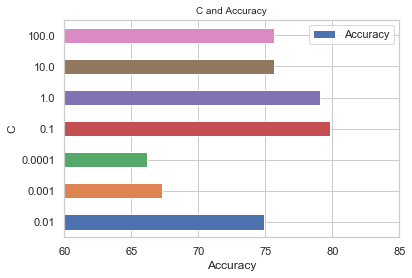

In [148]:
C_Accuracy.plot(x = 'C', y = 'Accuracy', kind='barh', use_index=True)
plt.xlabel('Accuracy')
plt.xlim(60, 85)
plt.title('C and Accuracy', size = 10)

#### C=0.1 results in max accuracy for L2 regularization

## 4.2) Different values of C for L1 regularization

In [149]:
# Create logistic regression object
logC_score_train = []
logC_score_test = []
logC_acc = []
for i in range(len(hparameters['C'])):
    logC = LogisticRegression(C=hparameters['C'][i], penalty='l1')

    logC.fit(X_train, y_train)
    logC_pred = logC.predict(X_test)
    temp_s = round(logC.score(X_train, y_train) * 100, 2)
    logC_score_train += [round(logC.score(X_train, y_train) * 100, 2)]
    logC_score_test += [round(logC.score(X_test, y_test) * 100, 2)]
    logC_acc += [round(accuracy_score(y_test, logC_pred)*100, 2)]

In [150]:
logC_acc

[66.16, 65.02, 58.94, 78.71, 77.95, 75.67, 76.05]

In [151]:
C_Accuracy = pd.DataFrame({'C': hparameters['C'],
                                 'Accuracy': logC_acc})
C_Accuracy

,C,Accuracy
0,0.0100,66.16
1,0.0010,65.02
2,0.0001,58.94
3,0.1000,78.71
4,1.0000,77.95
5,10.0000,75.67
6,100.0000,76.05


Text(0.5,1,'C and Accuracy')

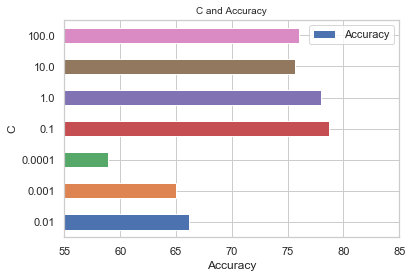

In [160]:
C_Accuracy.plot(x = 'C', y = 'Accuracy', kind='barh', use_index=True)
plt.xlabel('Accuracy')
plt.xlim(55, 85)
plt.title('C and Accuracy', size = 10)

#### C=0.1 results in max accuracy for L1 regularization

# 5)  Comparison of different models

## 5.1) Accuracy Comparison

In [153]:
model_comparison = pd.DataFrame({'Parameters': ['C=1,cv5, L1', 'C=1,cv5, L2',
                                           'C=1,cv10, L1', 'C=1,cv10, L2',
                                           'C=1,cv20, L1', 'C=10,cv20, L2'],
                                 'Accuracy': [gsl1cv5_acc*100, gsl2cv5_acc*100, gsl1cv10_acc*100, 
                                         gsl2cv10_acc*100, gsl1cv20_acc*100, gsl2cv20_acc*100]})
model_comparison

,Parameters,Accuracy
0,"C=1,cv5, L1",77.946768
1,"C=1,cv5, L2",79.087452
2,"C=1,cv10, L1",77.946768
3,"C=1,cv10, L2",79.087452
4,"C=1,cv20, L1",77.946768
5,"C=10,cv20, L2",75.665399


Text(0.5,1,'Parameters and Accuracy')

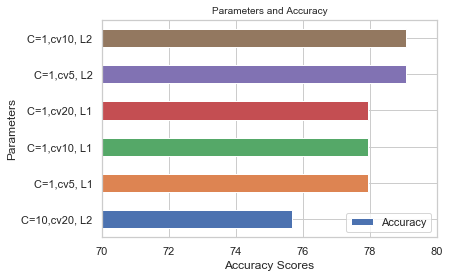

In [155]:
model_comparison.sort_values('Accuracy', ascending = True).plot(x = 'Parameters', y = 'Accuracy', kind='barh', use_index=True)
plt.xlabel('Accuracy Scores')
plt.xlim(70, 80)
plt.title('Parameters and Accuracy', size = 10)

#### C=1, cv=5&10 and L2 has more accuracy compared to models with other hyperparameters

## 5.2) Precision
Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate. We have got 0.788 precision which is pretty good.

Precision = TP/TP+FP

Text(0.5,1,'Parameters and Precision')

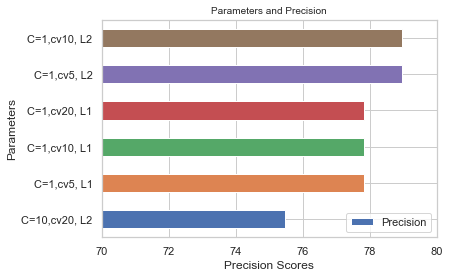

In [157]:
precision_model_comparison = pd.DataFrame({'Parameters': ['C=1,cv5, L1', 'C=1,cv5, L2',
                                           'C=1,cv10, L1', 'C=1,cv10, L2',
                                           'C=1,cv20, L1', 'C=10,cv20, L2'],
                                 'Precision': [gsl1cv5_pr*100, gsl2cv5_pr*100, gsl1cv10_pr*100, 
                                         gsl2cv10_pr*100, gsl1cv20_pr*100, gsl2cv20_pr*100]})

precision_model_comparison.sort_values('Precision', ascending = True).plot(x = 'Parameters', y = 'Precision', kind='barh', use_index=True)
plt.xlabel('Precision Scores')
plt.xlim(70, 80)
plt.title('Parameters and Precision', size = 10)

#### C=1, cv=5&10 and L2 has more precision compared to models with other hyperparameters

## 5.3) Recall / Sensitivity
Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? We have got recall of 0.631 which is good for this model as it’s above 0.5.

Recall = TP/TP+FN

Text(0.5,1,'Parameters and Recall')

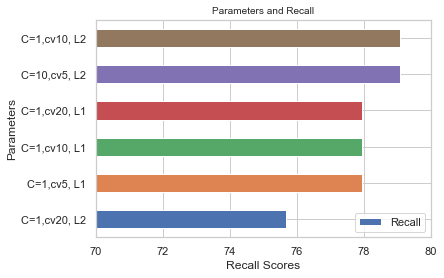

In [158]:
recall_model_comparison = pd.DataFrame({'Parameters': ['C=1,cv5, L1', 'C=10,cv5, L2',
                                           'C=1,cv10, L1', 'C=1,cv10, L2',
                                           'C=1,cv20, L1', 'C=1,cv20, L2'],
                                 'Recall': [gsl1cv5_rec*100, gsl2cv5_rec*100, gsl1cv10_rec*100, 
                                         gsl2cv10_rec*100, gsl1cv20_rec*100, gsl2cv20_rec*100]})

recall_model_comparison.sort_values('Recall', ascending = True).plot(x = 'Parameters', y = 'Recall', kind='barh', use_index=True)
plt.xlabel('Recall Scores')
plt.xlim(70, 80)
plt.title('Parameters and Recall', size = 10)

#### C=1 cv=10& C=1, cv=5 and L2 has more recall score compared to models with other hyperparameters

## 5.4) F1 Score
F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)

Text(0.5,1,'Parameters and F1')

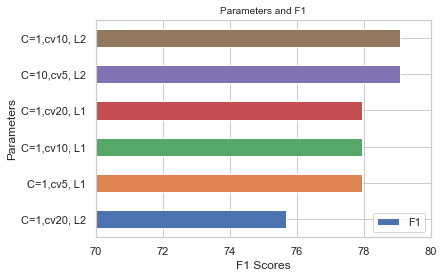

In [159]:
f1_model_comparison = pd.DataFrame({'Parameters': ['C=1,cv5, L1', 'C=10,cv5, L2',
                                           'C=1,cv10, L1', 'C=1,cv10, L2',
                                           'C=1,cv20, L1', 'C=1,cv20, L2'],
                                 'F1': [gsl1cv5_rec*100, gsl2cv5_rec*100, gsl1cv10_rec*100, 
                                         gsl2cv10_rec*100, gsl1cv20_rec*100, gsl2cv20_rec*100]})

f1_model_comparison.sort_values('F1', ascending = True).plot(x = 'Parameters', y = 'F1', kind='barh', use_index=True)
plt.xlabel('F1 Scores')
plt.xlim(70, 80)
plt.title('Parameters and F1', size = 10)

#### C=1 cv=10 & C=1 cv=5 and L2  has better f1 score precision compared to models with other hyperparameters

# 6) Conclusion

#### Model with better accuracy, precision is C=1, cv=5 & 10 with L2 regulatization.
#### Model with better recall & f1 is C=1 cv=10 & C=1 cv=5 with L2 regulatization. The data is balanced and hence we dont need to focus on recall and f1.
#### For different values of C, the accuracy outcome was better for model with C=0.1 with L2
